In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'
os.environ['MKL_NUM_THREADS'] = '1'


import numpy as np
import scipy
import matplotlib.pyplot as plt
import wannierberri as wberri
from wannierberri import calculators as calc

#  This block is needed if you run this cell for a second time
#  because one cannot initiate two parallel environments at a time
try:
    parallel.shutdown()
except NameError:
    pass

parallel = wberri.Parallel(num_cpus=4, progress_step_percent=10)

2023-03-02 13:21:38,097	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


In [23]:
import wannierberri.models

# Initiate a tight-binding model (wannierberri.models.Chiral uses PythTB)
model_Chiral_left = wannierberri.models.Chiral(delta=2., hop1=1., hop2=0.3, phi=0, hopz_left=0.2, hopz_right=0.0, hopz_vert=0)

# Initialize WannierBerri system object
system = wberri.System_PythTB(model_Chiral_left, use_wcc_phase=True)

print("=" * 40)

# Set symmetry from the generators.
system.set_symmetry(["TimeReversal", "C3z"])
print("Number of symmetry operations: ", system.symgroup.size)

R=0 found at position(s) [[10]]
NOT using ws_dist
Number of wannier functions: 2
Number of R points: 21
Recommended size of FFT grid [3 3 3]
Reading the system from PythTB finished successfully
Number of symmetry operations:  6


In [24]:
path = wberri.Path(
    system,
    k_nodes=[
        [2/3, 1/3, 0.],  #  K
        [0.,  0.,  0.],  #  Gamma
        [1/2, 0.,  0.],  #  M
        [2/3, 1/3, 0.],  #  K
        [2/3, 1/3, 0.5],  #  H
        [0.,  0.,  0.5],  #  A
        [1/2, 0.,  0.5],  #  L
        [2/3, 1/3, 0.5],  #  H
    ],
    labels=["K","$\Gamma$","M","K", "H", "A", "L", "H"],
    length=50
)

calculators = {
    "tabulate": calc.TabulatorAll(
        {"Energy": calc.tabulate.Energy()},
        ibands=np.arange(system.num_wann),
        mode="path",
    )
}

path_result = wberri.run(
    system,
    grid=path,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

path_result = path_result.results["tabulate"]

calculator not described

Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.TabulatorAll object at 0x12e8b84c0>
All calculators are compatible
Symmetrization switched off for Path
The set of k points is a Path() with 184 points and labels {0: 'K', 33: '$\\Gamma$', 62: 'M', 79: 'K', 104: 'H', 137: 'A', 166: 'L', 183: 'H'}
generating K_list
Done 
Done, sum of weights:184.0
symgroup : None
processing 184 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
                  18              0.0                   0.5
                  36              0.1                   0.2
                  54              0.1                   0.1
                  72              0.1                   0.1
                  90              0.1                   0.1
                 108              0.1                   0.1
                 126              0.1                   0.0
                 144            

Valence band maximum   : -0.606
Conduction band minimum: -0.099
VBM k point:  [0. 0. 0.]
CBM k point:  [0.66666667 0.33333333 0.16      ]


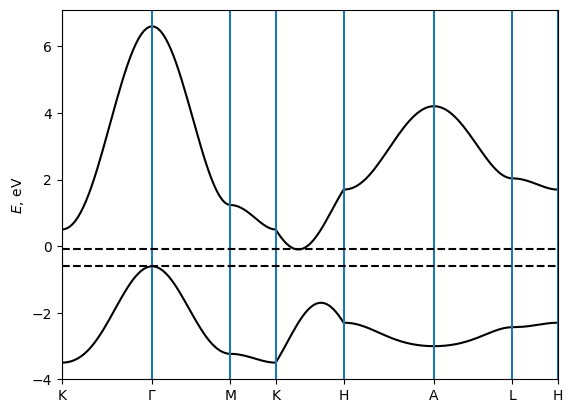

In [25]:
e_vbm = np.amax(path_result.get_data("Energy", 0))
e_cbm = np.amin(path_result.get_data("Energy", 1))
print(f"Valence band maximum   : {e_vbm:6.3f}")
print(f"Conduction band minimum: {e_cbm:6.3f}")

print("VBM k point: ", path_result.kpoints[np.argmax(path_result.get_data("Energy", 0))])
print("CBM k point: ", path_result.kpoints[np.argmin(path_result.get_data("Energy", 1))])

fig = path_result.plot_path_fat(path, close_fig=False, show_fig=False)

ax = fig.get_axes()[0]
ax.axhline(e_vbm, c="k", ls="--")
ax.axhline(e_cbm, c="k", ls="--")
plt.show(fig)

In [6]:
from wannierberri.smoother import FermiDiracSmoother

efermi = np.linspace(-2.0, 1.0, 101, True)
# efermi = np.linspace(e_vbm - 0.5, e_cbm + 0.5, 301, True)

kwargs = dict(
    Efermi=efermi,
    kwargs_formula={"external_terms": False},
    smoother=FermiDiracSmoother(efermi, T_Kelvin=1200, maxdE=8)
)

calculators = {
    'berry_dipole_fermi_sea': calc.static.BerryDipole_FermiSea(**kwargs),
    'berry_dipole_fermi_surface': calc.static.BerryDipole_FermiSurf(**kwargs),
    'dos': calc.static.DOS(Efermi=efermi,),
}

Berry curvature dipole (dimensionless)

        | With Fermi sea integral. Eq(29) in `Ref <https://www.nature.com/articles/s41524-021-00498-5>`_
        | Output: :math:`D_{\beta\delta} = \int [dk] \partial_\beta \Omega_\delta f`

Berry curvature dipole (dimensionless)

        | With Fermi surface integral. Eq(8) in `Ref <https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.115.216806>`_
        | Output: :math:`D_{\beta\delta} = -\int [dk] v_\beta \Omega_\delta f'`

Density of states



In [7]:
grid = wberri.Grid(system, NK=20, NKFFT=2)
print("=" * 40)
print("Calculation using the full k-point grid")
result_full_grid = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
    use_irred_kpt = False,
)

print("=" * 40)
print("Calculation using the irreducible k-point grid")
result_irr_grid = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
    use_irred_kpt = True,
)

determining grids from NK=20 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=2 (<class 'NoneType'>)
The grids were set to NKdiv=[10 10 10], NKFFT=[2 2 2], NKtot=[20 20 20]
Calculation using the full k-point grid
Grid is regular
The set of k points is a Grid() with NKdiv=[10 10 10], NKFFT=[2 2 2], NKtot=[20 20 20]
generating K_list
Done in 0.003103017807006836 s 
Done in 0.0031349658966064453 s 
K_list contains 1000 Irreducible points(100.0%) out of initial 10x10x10=1000 grid
Done, sum of weights:1.0000000000000007
symgroup : <wannierberri.symmetry.Group object at 0x123e418e0>
processing 1000 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
                 100              0.2                   1.5
                 200              0.2                   1.0
                 300              0.3                   0.8
                 400              0.5                   0.8
                 500              0.6                   0.6
 

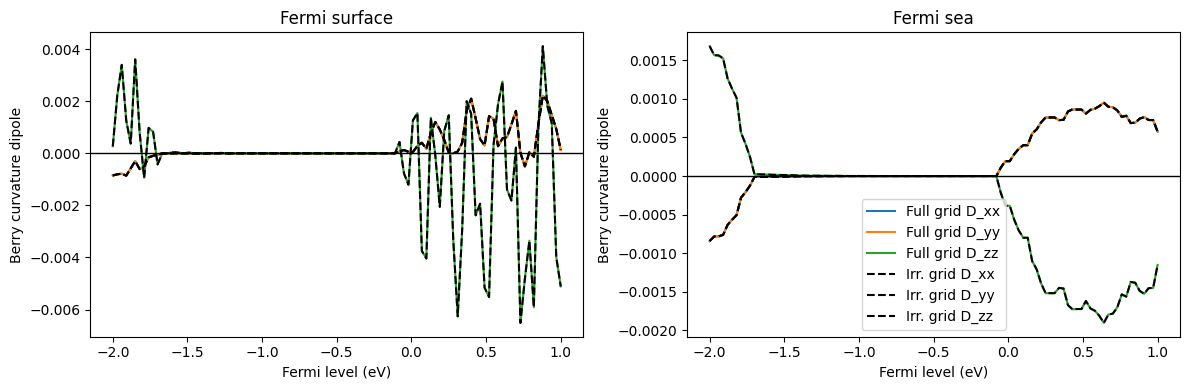

In [8]:
dir_string = ["D_xx", "D_yy", "D_zz"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for label, res in zip(["Full grid", "Irr. grid"], [result_full_grid, result_irr_grid]):
    data_fsurf = res.results['berry_dipole_fermi_surface'].data
    data_fsea = res.results['berry_dipole_fermi_sea'].data
    for i in range(3):
        if label == "Full grid":
            fmt = f"C{i}-"
        else:
            fmt = "k--"
        axes[0].plot(efermi, data_fsurf[:, i, i], fmt, label=label + " " + dir_string[i])
        axes[1].plot(efermi, data_fsea[:, i, i], fmt, label=label + " " + dir_string[i])

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

In [9]:
grid = wberri.Grid(system, NK=20, NKFFT=2)
result = wberri.run(
    system,
    grid=grid,
    calculators=calculators,
    parallel=parallel,
    print_Kpoints = False,
)

determining grids from NK=20 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=2 (<class 'NoneType'>)
The grids were set to NKdiv=[10 10 10], NKFFT=[2 2 2], NKtot=[20 20 20]
Grid is regular
The set of k points is a Grid() with NKdiv=[10 10 10], NKFFT=[2 2 2], NKtot=[20 20 20]
generating K_list
Done in 0.004022836685180664 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.038548946380615234 s 
Done in 0.03858590126037598 s 
K_list contains 172 Irreducible points(17.2%) out of initial 10x10x10=1000 grid
Done, sum of weights:1.0000000000000007
symgroup : <wannierberri.symmetry.Group object at 0x123e418e0>
processing 172 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
                  17              0.1                   0.8
                  34              0.1                   0.5
                  51              0.2                   0.4
                  68              0.2                   0.3
                 

In [10]:
data_fsurf = result.results['berry_dipole_fermi_surface'].data
data_fsea = result.results['berry_dipole_fermi_sea'].data

print("Shape of data: ", data_fsurf.shape)

print("Maximum value for each components (Fermi surface): ")
print(np.linalg.norm(data_fsurf, axis=0))

print("Maximum value for each components (Fermi sea): ")
print(np.linalg.norm(data_fsea, axis=0))

Shape of data:  (101, 3, 3)
Maximum value for each components (Fermi surface): 
[[6.21590176e-03 7.98124588e-19 5.03385496e-18]
 [1.19379214e-18 6.21590176e-03 1.24379144e-18]
 [8.22553065e-19 1.93110747e-19 2.01147852e-02]]
Maximum value for each components (Fermi sea): 
[[4.68803509e-03 8.35316628e-19 1.30645509e-17]
 [2.40653318e-18 4.68803509e-03 1.35949761e-18]
 [5.62614568e-19 2.85967219e-19 9.37607018e-03]]


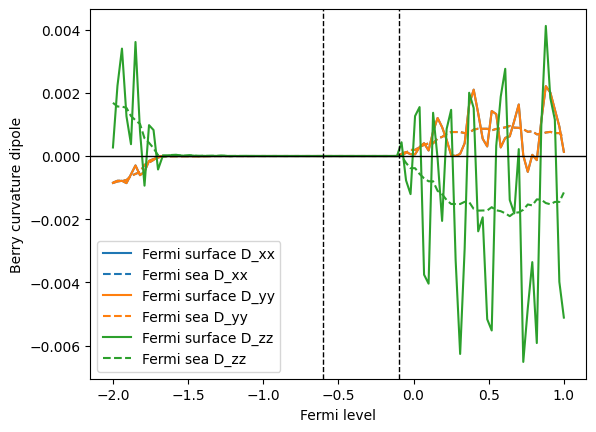

In [11]:
dir_string = ["D_xx", "D_yy", "D_zz"]
for i in range(3):
    plt.plot(efermi, data_fsurf[:, i, i], c=f"C{i}", label="Fermi surface " + dir_string[i])
    plt.plot(efermi, data_fsea[:, i, i], c=f"C{i}", label="Fermi sea " + dir_string[i], ls="--")

# plt.plot(efermi, result.results['dos'].data, "k-")

plt.axhline(0, c="k", lw=1)
plt.xlabel("Fermi level")
plt.ylabel("Berry curvature dipole")
plt.axvline(e_vbm, c="k", lw=1, ls="--")
plt.axvline(e_cbm, c="k", lw=1, ls="--")
plt.legend()
plt.show()

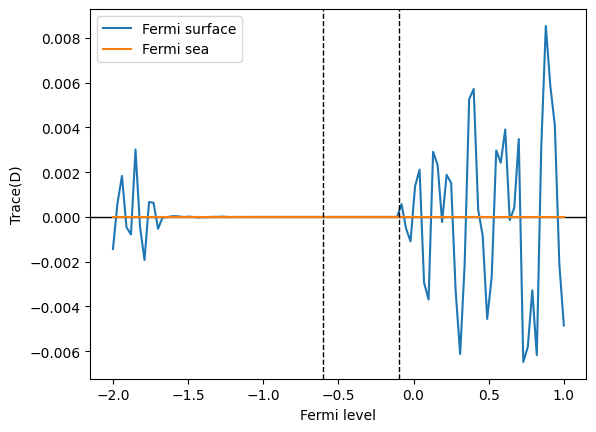

In [12]:
data_fsurf_trace = np.trace(data_fsurf, axis1=1, axis2=2)
data_fsea_trace = np.trace(data_fsea, axis1=1, axis2=2)

plt.plot(efermi, data_fsurf_trace, label="Fermi surface")
plt.plot(efermi, data_fsea_trace, label="Fermi sea")

plt.axhline(0, c="k", lw=1, zorder=1)
plt.xlabel("Fermi level")
plt.ylabel("Trace(D)")
plt.axvline(e_vbm, c="k", lw=1, ls="--")
plt.axvline(e_cbm, c="k", lw=1, ls="--")
plt.legend()
plt.show()

In [13]:
data_fsurf_all = {}
data_fsea_all = {}

for nk in [20, 40, 60, 80]:
    grid = wberri.Grid(system, NK=nk)
    result = wberri.run(
        system,
        grid=grid,
        calculators=calculators,
        parallel=parallel,
        print_Kpoints = False,
    )
    data_fsurf_all[nk] = result.results['berry_dipole_fermi_surface'].data
    data_fsea_all[nk] = result.results['berry_dipole_fermi_sea'].data

determining grids from NK=20 (<class 'int'>), NKdiv=None (<class 'NoneType'>), NKFFT=None (<class 'NoneType'>)
Minimal symmetric FFT grid :  [3 3 3]
The grids were set to NKdiv=[5 5 5], NKFFT=[4 4 4], NKtot=[20 20 20]
Grid is regular
The set of k points is a Grid() with NKdiv=[5 5 5], NKFFT=[4 4 4], NKtot=[20 20 20]
generating K_list
Done in 0.0006220340728759766 s 
excluding symmetry-equivalent K-points from initial grid
Done in 0.007317066192626953 s 
Done in 0.0073299407958984375 s 
K_list contains 23 Irreducible points(18.4%) out of initial 5x5x5=125 grid
Done, sum of weights:1.0000000000000002
symgroup : <wannierberri.symmetry.Group object at 0x123e418e0>
processing 23 K points : using  4 processes.
# K-points calculated  Wall time (sec)  Est. remaining (sec)
                   4              0.0                   0.2
                   8              0.1                   0.1
                  12              0.1                   0.1
                  16              0.1        

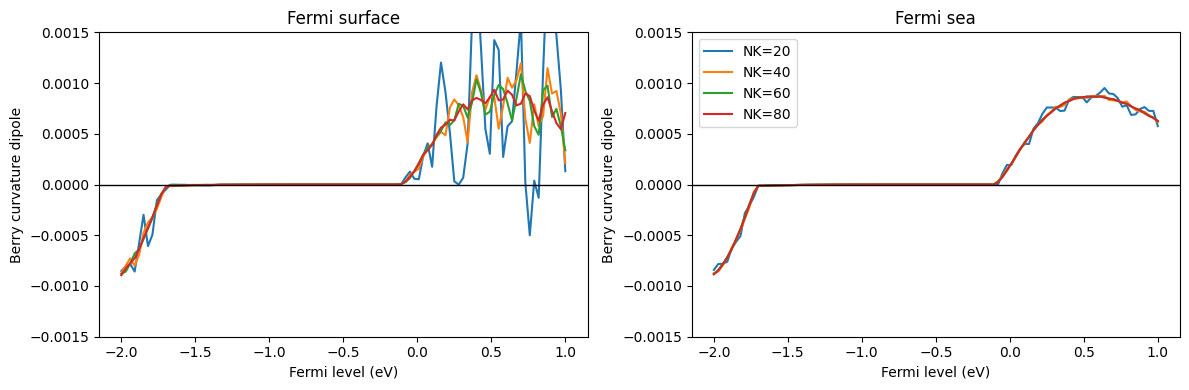

In [14]:
ic = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
nklist = sorted(list(data_fsurf_all.keys()))

for nk in nklist:
    c = f"C{ic}"
    axes[0].plot(efermi, data_fsurf_all[nk][:, 0, 0], c=c, label=f"NK={nk}")
    axes[1].plot(efermi, data_fsea_all[nk][:, 0, 0], c=c, label=f"NK={nk}")
    ic += 1

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.set_ylim([-1.5e-3, 1.5e-3])
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

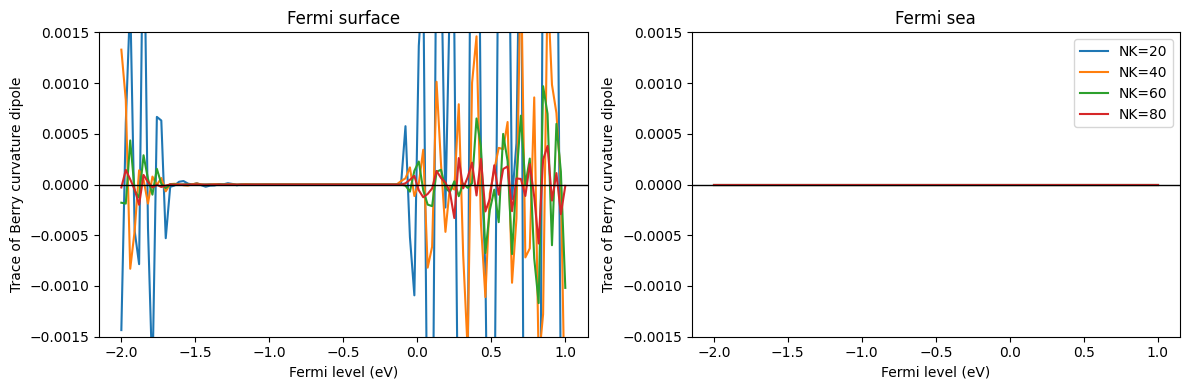

In [15]:
ic = 0
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
for nk in sorted(list(data_fsurf_all.keys())):
    c = f"C{ic}"
    axes[0].plot(efermi, np.trace(data_fsurf_all[nk], axis1=1, axis2=2), c=c, label=f"NK={nk}")
    axes[1].plot(efermi, np.trace(data_fsea_all[nk], axis1=1, axis2=2), c=c, label=f"NK={nk}")
    ic += 1

axes[0].set_title("Fermi surface")
axes[1].set_title("Fermi sea")

for ax in axes:
    ax.axhline(0, c="k", lw=1)
    ax.set_ylim([-1.5e-3, 1.5e-3])
    ax.set_xlabel("Fermi level (eV)")
    ax.set_ylabel("Trace of Berry curvature dipole")

axes[1].legend()
plt.tight_layout()
plt.show()

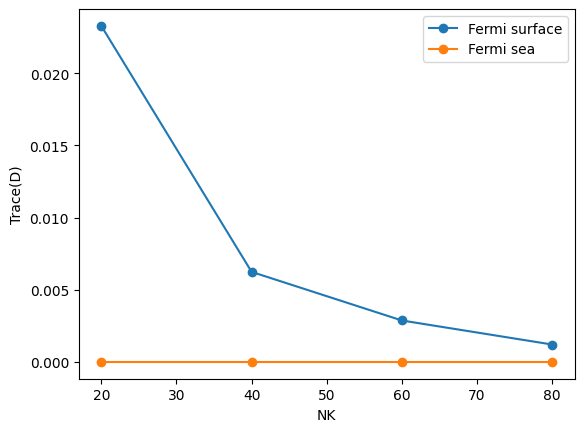

In [16]:
nklist = sorted(list(data_fsurf_all.keys()))
plt.plot(nklist, [np.linalg.norm(np.trace(data_fsurf_all[nk], axis1=1, axis2=2)) for nk in nklist], "o-", label="Fermi surface")
plt.plot(nklist, [np.linalg.norm(np.trace(data_fsea_all[nk], axis1=1, axis2=2)) for nk in nklist], "o-", label="Fermi sea")
plt.legend()
plt.xlabel("NK")
plt.ylabel("Trace(D)")
# plt.yscale("log")
plt.show()